In [2]:
import torch
torch.__version__

'1.1.0'

In [1]:
import numpy as np

PATH_to_log_dir = '/data/cv_final/CT-Predict/2D-Pretrain/result' # 如果输出路径不存在会被自动创建
# writer = SummaryWriter(PATH_to_log_dir)
# writer = SummaryWriter()


# for n_iter in range(100):
#     writer.add_scalar('Loss/train', np.random.random(), n_iter)
#     writer.add_scalar('Accuracy/train', np.random.random(), n_iter)

In [2]:
# %tensorboard --logdir=runs

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [4]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [5]:
batchsize=8
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        - root_dir /data/Data/
            - COVID19
                - img1.png
                - img2.png
                - ......
            - Normal
                - img1.png
                - img2.png
                - ......
        txt_path:
        - COVID19
            - test_COVID.txt
            - train_COVID.txt
            - val_COVID.txt
        - Normal
            - ...
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        # 2019
#         self.classes = ['COVID19', 'Normal']
        # UCSD
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
#             print(cls_list)
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample


if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
                              txt_COVID='/data/COVID-CT/Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
                              txt_COVID='/data/COVID-CT/Data-split/COVID/valCT_COVID.txt',
                              txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
                              txt_COVID='/data/COVID-CT/Data-split/COVID/testCT_COVID.txt',
                              txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
                              transform= val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


torch.Size([8, 3, 224, 224])


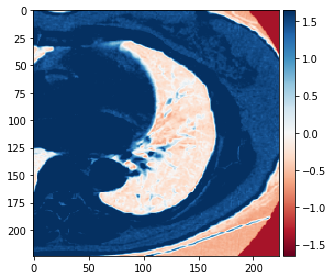

In [82]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
        break
# io.imread 读出图片格式是 uint8(unsigned int) ；value是 numpy array ；
# 图像数据是以 RGB 的格式进行存储的，通道值默认范围0-255
skimage.io.imshow(data[0,1,:,:].numpy())
print(data.shape)

In [85]:
# mixup
'''Use mixup to do data augmentation'''

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
#         print('lam',lam)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     print(pred)
#     print(y_a)
#     print('criterion',criterion(pred, y_a))
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [8]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    his['train_loss'].append(train_loss.data.cpu().numpy()/len(train_loader.dataset))
    his['train_acc'].append(train_correct / len(train_loader.dataset))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
    p = os.path.join(PATH_to_log_dir,'/baseline_{}.txt'.format(modelname))
    f = open(p, 'a+')
    f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    f.write('\n')
    f.close()

In [9]:
# #val process is defined here

def val(epoch):
    
    model.eval()
    val_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            val_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        his['val_loss'].append(val_loss.data.cpu().numpy()/len(val_loader.dataset))
        his['val_acc'].append(correct/len(val_loader.dataset))       
    return targetlist, scorelist, predlist


In [10]:
# test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        his['test_loss'].append(test_loss.data.cpu().numpy()/len(test_loader.dataset))
        his['test_acc'].append(correct/len(test_loader.dataset))
    return targetlist, scorelist, predlist
    

In [14]:
# """Load Self-Trans model"""
# """Change names and locations to the Self-Trans.pt"""
"baseline"
import torchvision.models as models

model = models.densenet169(pretrained=True).cuda()

modelname = 'Dense169_baseline'

In [15]:
his = {}
his['train_loss'] = []
his['train_acc'] = []
his['val_loss'] = []
his['val_acc'] = []
his['test_loss'] = []
his['test_acc'] = []

In [ ]:
import datetime
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

lr = 0.001
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
                                             
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 500
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "/data/cv_final/CT-Predict/2D-Pretrain/result/UCSD_{}_{}_{}_{}.pt".format(modelname,alpha_name,epoch, datetime.datetime.now()))  

        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open('/data/cv_final/CT-Predict/2D-Pretrain/result/UCSD_{}_{}_{}_{}.txt'.format(modelname,alpha_name, epoch, lr), 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))\
        
        f.close()

Train Epoch: 1 [0/54 (0%)]	Train Loss: 1.068091
Train Epoch: 1 [8/54 (15%)]	Train Loss: 0.328159
Train Epoch: 1 [16/54 (30%)]	Train Loss: 0.173053
Train Epoch: 1 [24/54 (44%)]	Train Loss: 0.045815
Train Epoch: 1 [32/54 (59%)]	Train Loss: 0.118430
Train Epoch: 1 [40/54 (74%)]	Train Loss: 0.048406
Train Epoch: 1 [48/54 (89%)]	Train Loss: 0.064237
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.62010178e-01 9.57466245e-01 9.21583951e-01 5.07854760e-01
 3.75627950e-02 8.82275850e-02 9.68153298e-01 1.78135321e-01
 3.65944393e-02 4.39214054e-05 1.43312471e-04 3.17853710e-06
 1.03099681e-02 9.31692719e-01 9.93846953e-01 7.05711835e-04
 3.50472110e-05 2.48444546e-03 1.969

Train Epoch: 5 [0/54 (0%)]	Train Loss: 0.066584
Train Epoch: 5 [8/54 (15%)]	Train Loss: 0.072480
Train Epoch: 5 [16/54 (30%)]	Train Loss: 0.053115
Train Epoch: 5 [24/54 (44%)]	Train Loss: 0.082473
Train Epoch: 5 [32/54 (59%)]	Train Loss: 0.065363
Train Epoch: 5 [40/54 (74%)]	Train Loss: 0.050917
Train Epoch: 5 [48/54 (89%)]	Train Loss: 0.086234
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99275827 0.9991473  0.99932587 0.88073969 0.95470512 0.92970526
 0.99930632 0.93536693 0.26607555 0.60843384 0.44271886 0.60559416
 0.74174613 0.80639058 0.86493951 0.66330177 0.56314749 0.84928602
 0.7219432  0.67941487 0.81622612 0.87049043 0.93854225 0.78657591
 0.73022306 

Train Epoch: 9 [0/54 (0%)]	Train Loss: 0.085707
Train Epoch: 9 [8/54 (15%)]	Train Loss: 0.071456
Train Epoch: 9 [16/54 (30%)]	Train Loss: 0.088313
Train Epoch: 9 [24/54 (44%)]	Train Loss: 0.057509
Train Epoch: 9 [32/54 (59%)]	Train Loss: 0.064636
Train Epoch: 9 [40/54 (74%)]	Train Loss: 0.065840
Train Epoch: 9 [48/54 (89%)]	Train Loss: 0.074820
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.5056479  0.96332246 0.94821697 0.9981668  1.         0.54361707
 0.93943471 0.99939823 0.94668329 0.9999944  1.         0.99996316
 1.         0.76045787 0.71724445 1.         0.99995542 0.71931672
 0.96316993 0.8026306  0.99852657 0.68297654 0.58582222 0.34936407
 0.87803549 

Train Epoch: 12 [0/54 (0%)]	Train Loss: 0.082212
Train Epoch: 12 [8/54 (15%)]	Train Loss: 0.117085
Train Epoch: 12 [16/54 (30%)]	Train Loss: 0.077389
Train Epoch: 12 [24/54 (44%)]	Train Loss: 0.107172
Train Epoch: 12 [32/54 (59%)]	Train Loss: 0.054865
Train Epoch: 12 [40/54 (74%)]	Train Loss: 0.112333
Train Epoch: 12 [48/54 (89%)]	Train Loss: 0.037097
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.87886316 0.91272807 0.73604417 0.55468529 0.35917065 0.82072496
 0.86077976 0.85249126 0.82431096 0.1656151  0.36018518 0.14962392
 0.481177   0.74233031 0.79568791 0.37954816 0.35080457 0.40534335
 0.55405504 0.57173252 0.47044817 0.57226223 0.58535838 0.32046375
 0.61

Train Epoch: 16 [0/54 (0%)]	Train Loss: 0.102760
Train Epoch: 16 [8/54 (15%)]	Train Loss: 0.073690
Train Epoch: 16 [16/54 (30%)]	Train Loss: 0.052729
Train Epoch: 16 [24/54 (44%)]	Train Loss: 0.096236
Train Epoch: 16 [32/54 (59%)]	Train Loss: 0.074952
Train Epoch: 16 [40/54 (74%)]	Train Loss: 0.039784
Train Epoch: 16 [48/54 (89%)]	Train Loss: 0.040080
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.79227167 0.94674057 0.85115707 0.7480287  0.59475631 0.53879249
 0.83248347 0.8346132  0.3549228  0.1493452  0.38193575 0.15782863
 0.44753098 0.84932035 0.90926707 0.56180662 0.47644335 0.42631388
 0.37494379 0.40911758 0.42980009 0.50100034 0.55717307 0.47058135
 0.55

Train Epoch: 20 [0/54 (0%)]	Train Loss: 0.078907
Train Epoch: 20 [8/54 (15%)]	Train Loss: 0.068854
Train Epoch: 20 [16/54 (30%)]	Train Loss: 0.106400
Train Epoch: 20 [24/54 (44%)]	Train Loss: 0.093773
Train Epoch: 20 [32/54 (59%)]	Train Loss: 0.115764
Train Epoch: 20 [40/54 (74%)]	Train Loss: 0.088996
Train Epoch: 20 [48/54 (89%)]	Train Loss: 0.050585
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.54272825 1.         1.         1.         0.99926454 0.73853332
 1.         1.         0.99497426 0.28174174 0.9549976  0.83618665
 0.99991834 1.         1.         1.         1.         0.96251225
 0.99253803 0.99670106 0.99997604 0.8892265  0.99427116 0.99855226
 0.99

Train Epoch: 23 [0/54 (0%)]	Train Loss: 0.122564
Train Epoch: 23 [8/54 (15%)]	Train Loss: 0.050632
Train Epoch: 23 [16/54 (30%)]	Train Loss: 0.076345
Train Epoch: 23 [24/54 (44%)]	Train Loss: 0.075755
Train Epoch: 23 [32/54 (59%)]	Train Loss: 0.060962
Train Epoch: 23 [40/54 (74%)]	Train Loss: 0.083662
Train Epoch: 23 [48/54 (89%)]	Train Loss: 0.155416
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.40538496 0.64244246 0.64175093 0.58882982 0.57505226 0.52586555
 0.63413244 0.56957841 0.69024926 0.82295281 0.66121459 0.73107785
 0.65011346 0.59817702 0.59742582 0.45762953 0.49524996 0.32408091
 0.474839   0.65200865 0.55605406 0.45496204 0.58671361 0.52076352
 0.46

Train Epoch: 27 [0/54 (0%)]	Train Loss: 0.118145
Train Epoch: 27 [8/54 (15%)]	Train Loss: 0.089661
Train Epoch: 27 [16/54 (30%)]	Train Loss: 0.094957
Train Epoch: 27 [24/54 (44%)]	Train Loss: 0.091854
Train Epoch: 27 [32/54 (59%)]	Train Loss: 0.070085
Train Epoch: 27 [40/54 (74%)]	Train Loss: 0.048863
Train Epoch: 27 [48/54 (89%)]	Train Loss: 0.069357
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.53587687e-01 9.42690194e-01 9.15289283e-01 7.75497735e-01
 7.07215130e-01 7.08347261e-01 7.38135755e-01 8.32830787e-01
 6.80210829e-01 1.53205469e-01 2.18008727e-01 2.26996154e-01
 5.03553033e-01 7.62935400e-01 8.60909224e-01 6.62112594e-01
 5.66339672e-01 4.19474036e-0

Train Epoch: 30 [0/54 (0%)]	Train Loss: 0.085793
Train Epoch: 30 [8/54 (15%)]	Train Loss: 0.082417
Train Epoch: 30 [16/54 (30%)]	Train Loss: 0.070434
Train Epoch: 30 [24/54 (44%)]	Train Loss: 0.100938
Train Epoch: 30 [32/54 (59%)]	Train Loss: 0.081627
Train Epoch: 30 [40/54 (74%)]	Train Loss: 0.061732
Train Epoch: 30 [48/54 (89%)]	Train Loss: 0.079095
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.75429201 0.80856407 0.795699   0.7755881  0.74679554 0.7170161
 0.79384542 0.79461128 0.72135812 0.43030357 0.70984632 0.52809316
 0.71696746 0.8310653  0.83140409 0.76274872 0.77474964 0.71301633
 0.73210758 0.71400517 0.65514553 0.74629033 0.76452559 0.68947917
 0.761

Train Epoch: 33 [0/54 (0%)]	Train Loss: 0.098437
Train Epoch: 33 [8/54 (15%)]	Train Loss: 0.129646
Train Epoch: 33 [16/54 (30%)]	Train Loss: 0.081873
Train Epoch: 33 [24/54 (44%)]	Train Loss: 0.090786
Train Epoch: 33 [32/54 (59%)]	Train Loss: 0.099500
Train Epoch: 33 [40/54 (74%)]	Train Loss: 0.095316
Train Epoch: 33 [48/54 (89%)]	Train Loss: 0.061235
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.58151293 0.86518663 0.85508919 0.30654272 0.17783527 0.18539603
 0.77262044 0.51874608 0.12602548 0.04576751 0.28409818 0.05410649
 0.16699749 0.57687271 0.68413115 0.18206131 0.17063393 0.1557304
 0.21134292 0.33922628 0.38354817 0.31113318 0.35659435 0.19822076
 0.345

Train Epoch: 37 [0/54 (0%)]	Train Loss: 0.107601
Train Epoch: 37 [8/54 (15%)]	Train Loss: 0.088593
Train Epoch: 37 [16/54 (30%)]	Train Loss: 0.065668
Train Epoch: 37 [24/54 (44%)]	Train Loss: 0.077821
Train Epoch: 37 [32/54 (59%)]	Train Loss: 0.073244
Train Epoch: 37 [40/54 (74%)]	Train Loss: 0.105116
Train Epoch: 37 [48/54 (89%)]	Train Loss: 0.082982
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.44006535 0.89230484 0.7607106  0.25657961 0.20639087 0.28859499
 0.77983886 0.52825344 0.16798654 0.08388256 0.07535111 0.06645706
 0.05815893 0.54774243 0.68017018 0.15439522 0.12523614 0.03930765
 0.26599208 0.28654999 0.33121219 0.19178683 0.40874061 0.45824498
 0.23


 The epoch is 40, average recall: 0.8276, average precision: 0.5581,average F1: 0.6667, average accuracy: 0.5932, average AUC: 0.6057
Train Epoch: 41 [0/54 (0%)]	Train Loss: 0.093739
Train Epoch: 41 [8/54 (15%)]	Train Loss: 0.130031
Train Epoch: 41 [16/54 (30%)]	Train Loss: 0.091262
Train Epoch: 41 [24/54 (44%)]	Train Loss: 0.075295
Train Epoch: 41 [32/54 (59%)]	Train Loss: 0.094715
Train Epoch: 41 [40/54 (74%)]	Train Loss: 0.071474
Train Epoch: 41 [48/54 (89%)]	Train Loss: 0.061870
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.76167786 0.92101556 0.90749246 0.71986157 0.55707341 0.56910694
 0.86208749 0.83645856 0.50982475 0.22649556 0.40943217 0.23216204
 0.3

Train Epoch: 45 [0/54 (0%)]	Train Loss: 0.156913
Train Epoch: 45 [8/54 (15%)]	Train Loss: 0.097287
Train Epoch: 45 [16/54 (30%)]	Train Loss: 0.047526
Train Epoch: 45 [24/54 (44%)]	Train Loss: 0.058574
Train Epoch: 45 [32/54 (59%)]	Train Loss: 0.067037
Train Epoch: 45 [40/54 (74%)]	Train Loss: 0.090190
Train Epoch: 45 [48/54 (89%)]	Train Loss: 0.093522
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99998927 0.99999344 1.         1.         0.99999988 0.99999845
 0.9998461  1.         1.         0.44879141 0.91940844 0.34261155
 0.98048651 0.99998331 0.9999969  0.99397111 0.96340418 0.99503869
 0.6464389  0.8040697  0.92856324 0.81233484 0.9975841  0.99567223
 0.69

Train Epoch: 49 [0/54 (0%)]	Train Loss: 0.068907
Train Epoch: 49 [8/54 (15%)]	Train Loss: 0.047720
Train Epoch: 49 [16/54 (30%)]	Train Loss: 0.055095
Train Epoch: 49 [24/54 (44%)]	Train Loss: 0.063583
Train Epoch: 49 [32/54 (59%)]	Train Loss: 0.104476
Train Epoch: 49 [40/54 (74%)]	Train Loss: 0.099044
Train Epoch: 49 [48/54 (89%)]	Train Loss: 0.050558
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.56427199 0.87250495 0.82882106 0.61920005 0.57278496 0.36432153
 0.71620768 0.83393484 0.29476991 0.21295866 0.31403312 0.30878031
 0.34903729 0.82238418 0.82764745 0.32176238 0.35720021 0.22943513
 0.34148291 0.42933935 0.54026788 0.3696098  0.74045956 0.86825353
 0.36

Train Epoch: 52 [0/54 (0%)]	Train Loss: 0.087250
Train Epoch: 52 [8/54 (15%)]	Train Loss: 0.084150
Train Epoch: 52 [16/54 (30%)]	Train Loss: 0.046921
Train Epoch: 52 [24/54 (44%)]	Train Loss: 0.065812
Train Epoch: 52 [32/54 (59%)]	Train Loss: 0.083577
Train Epoch: 52 [40/54 (74%)]	Train Loss: 0.082566
Train Epoch: 52 [48/54 (89%)]	Train Loss: 0.053067
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.91379768 0.90204334 0.89843857 0.94668531 0.94154018 0.9715324
 0.83088875 0.98838705 0.97992718 0.63376743 0.83781016 0.5220992
 0.80651563 0.94645131 0.91706085 0.72413057 0.97349495 0.8374126
 0.75106895 0.81534976 0.69469094 0.81867832 0.90995485 0.96928126
 0.77819

Train Epoch: 56 [0/54 (0%)]	Train Loss: 0.074844
Train Epoch: 56 [8/54 (15%)]	Train Loss: 0.078175
Train Epoch: 56 [16/54 (30%)]	Train Loss: 0.029946
Train Epoch: 56 [24/54 (44%)]	Train Loss: 0.099228
Train Epoch: 56 [32/54 (59%)]	Train Loss: 0.099373
Train Epoch: 56 [40/54 (74%)]	Train Loss: 0.077927
Train Epoch: 56 [48/54 (89%)]	Train Loss: 0.047038
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99710757 0.99999952 0.99999607 0.98536927 0.94751906 0.93881238
 0.99999833 0.99253309 0.86109072 0.14311214 0.23129186 0.19605529
 0.39918038 0.89985353 0.97691458 0.62622356 0.40288466 0.57278115
 0.51682848 0.56118292 0.68384248 0.63812989 0.93198025 0.93174422
 0.49

Train Epoch: 60 [0/54 (0%)]	Train Loss: 0.034931
Train Epoch: 60 [8/54 (15%)]	Train Loss: 0.091091
Train Epoch: 60 [16/54 (30%)]	Train Loss: 0.063056
Train Epoch: 60 [48/54 (89%)]	Train Loss: 0.060611
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.35726297 0.92816573 0.90571839 0.66526514 0.68053168 0.35048354
 0.93375796 0.8559854  0.24902336 0.11171889 0.50750339 0.17693636
 0.70562768 0.81782269 0.86945385 0.41358575 0.30350149 0.19064078
 0.28749248 0.42535499 0.50422704 0.35599574 0.68068832 0.81816089
 0.35360676 0.83088195 0.87508738 0.73079747 0.450836   0.41095862
 0.86330438 0.76433665 0.79391468 0.25854731 0.42680696 0.38273975
 0.41890454 0.37642068 0

Train Epoch: 63 [16/54 (30%)]	Train Loss: 0.110058
Train Epoch: 63 [24/54 (44%)]	Train Loss: 0.084084
Train Epoch: 63 [32/54 (59%)]	Train Loss: 0.082354
Train Epoch: 63 [40/54 (74%)]	Train Loss: 0.032230
Train Epoch: 63 [48/54 (89%)]	Train Loss: 0.065754
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.15697229 0.81911218 0.83907223 0.27145067 0.17810576 0.03051991
 0.74608237 0.48189902 0.01382873 0.01978544 0.12338626 0.06424188
 0.20366824 0.63381195 0.51683015 0.04234572 0.10628668 0.09094077
 0.30046192 0.60335141 0.82451385 0.42113626 0.90777844 0.95925343
 0.53990752 0.96799904 0.96015906 0.84172875 0.3763822  0.36337242
 0.8177405  0.65137231 0.79438037 0.0

Train Epoch: 67 [0/54 (0%)]	Train Loss: 0.037440
Train Epoch: 67 [8/54 (15%)]	Train Loss: 0.075671
Train Epoch: 67 [16/54 (30%)]	Train Loss: 0.096446
Train Epoch: 67 [24/54 (44%)]	Train Loss: 0.074441
Train Epoch: 67 [32/54 (59%)]	Train Loss: 0.051559
Train Epoch: 67 [40/54 (74%)]	Train Loss: 0.112061
Train Epoch: 67 [48/54 (89%)]	Train Loss: 0.052885
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.08166344 0.63951939 0.54161572 0.29413256 0.06498789 0.04012899
 0.55733788 0.55844176 0.04393854 0.00602962 0.08469211 0.01839551
 0.09754945 0.38229799 0.3625885  0.14647442 0.15375845 0.12105227
 0.08300297 0.32820663 0.43912181 0.16571601 0.75431001 0.7598058
 0.201


 The epoch is 70, average recall: 0.7586, average precision: 0.6027,average F1: 0.6718, average accuracy: 0.6356, average AUC: 0.6764
Train Epoch: 71 [0/54 (0%)]	Train Loss: 0.052171
Train Epoch: 71 [8/54 (15%)]	Train Loss: 0.030901
Train Epoch: 71 [16/54 (30%)]	Train Loss: 0.075858
Train Epoch: 71 [24/54 (44%)]	Train Loss: 0.076202
Train Epoch: 71 [32/54 (59%)]	Train Loss: 0.092139
Train Epoch: 71 [40/54 (74%)]	Train Loss: 0.023683
Train Epoch: 71 [48/54 (89%)]	Train Loss: 0.033020
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.44998452 0.82947665 0.7667926  0.89168644 0.95302415 0.07387055
 0.70009905 0.87950546 0.1259072  0.0572634  0.7399689  0.05813447
 0.7

Train Epoch: 75 [0/54 (0%)]	Train Loss: 0.037314
Train Epoch: 75 [8/54 (15%)]	Train Loss: 0.049264
Train Epoch: 75 [16/54 (30%)]	Train Loss: 0.110179
Train Epoch: 75 [24/54 (44%)]	Train Loss: 0.061221
Train Epoch: 75 [32/54 (59%)]	Train Loss: 0.039171
Train Epoch: 75 [40/54 (74%)]	Train Loss: 0.067533
Train Epoch: 75 [48/54 (89%)]	Train Loss: 0.033075
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.79363585 0.89760315 0.81133306 0.70208806 0.58886671 0.24854963
 0.76760459 0.86007416 0.4760575  0.05731949 0.39999738 0.08321768
 0.29468295 0.85839361 0.77972364 0.37124959 0.34495744 0.42946765
 0.35976365 0.29009053 0.60607189 0.66135925 0.83489662 0.98762983
 0.68

Train Epoch: 79 [0/54 (0%)]	Train Loss: 0.041894
Train Epoch: 79 [8/54 (15%)]	Train Loss: 0.045899
Train Epoch: 79 [16/54 (30%)]	Train Loss: 0.045351
Train Epoch: 79 [24/54 (44%)]	Train Loss: 0.062482
Train Epoch: 79 [32/54 (59%)]	Train Loss: 0.028497
Train Epoch: 79 [40/54 (74%)]	Train Loss: 0.067794
Train Epoch: 79 [48/54 (89%)]	Train Loss: 0.077569
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99829954 1.         0.99999976 0.99997604 0.99998856 0.99967706
 1.         0.99998498 0.95059282 0.62500644 0.85907388 0.27325249
 0.99749541 0.99993527 0.99915004 0.99804461 0.99992096 0.96127415
 0.32772702 0.99773693 0.87265414 0.99945813 0.99978524 0.99782181
 0.93

Train Epoch: 82 [0/54 (0%)]	Train Loss: 0.036196
Train Epoch: 82 [8/54 (15%)]	Train Loss: 0.088806
Train Epoch: 82 [16/54 (30%)]	Train Loss: 0.125458
Train Epoch: 82 [24/54 (44%)]	Train Loss: 0.039582
Train Epoch: 82 [32/54 (59%)]	Train Loss: 0.052449
Train Epoch: 82 [40/54 (74%)]	Train Loss: 0.059673
Train Epoch: 82 [48/54 (89%)]	Train Loss: 0.042498
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.80865955 0.95268416 0.93083572 0.89319634 0.91810876 0.90388024
 0.89452296 0.9938426  0.98294073 0.09953229 0.26625079 0.09789711
 0.43540904 0.82100934 0.67134482 0.45951086 0.85017079 0.74571359
 0.62932259 0.59749854 0.70528281 0.79542011 0.91504675 0.97770643
 0.67

Train Epoch: 86 [0/54 (0%)]	Train Loss: 0.059385
Train Epoch: 86 [8/54 (15%)]	Train Loss: 0.101623
Train Epoch: 86 [16/54 (30%)]	Train Loss: 0.067356
Train Epoch: 86 [24/54 (44%)]	Train Loss: 0.033632
Train Epoch: 86 [32/54 (59%)]	Train Loss: 0.046457
Train Epoch: 86 [40/54 (74%)]	Train Loss: 0.020930
Train Epoch: 86 [48/54 (89%)]	Train Loss: 0.014028
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.26380453 0.95914757 0.94558233 0.77032655 0.7296769  0.07281903
 0.90640444 0.91684568 0.18865022 0.01710651 0.75256044 0.0257134
 0.71765727 0.24814315 0.26087543 0.07422557 0.46762812 0.43983498
 0.46431774 0.70039999 0.70504957 0.77268404 0.95378613 0.99424571
 0.753

Train Epoch: 90 [0/54 (0%)]	Train Loss: 0.059775
Train Epoch: 90 [8/54 (15%)]	Train Loss: 0.085274
Train Epoch: 90 [16/54 (30%)]	Train Loss: 0.047481
Train Epoch: 90 [24/54 (44%)]	Train Loss: 0.053304
Train Epoch: 90 [32/54 (59%)]	Train Loss: 0.073308
Train Epoch: 90 [40/54 (74%)]	Train Loss: 0.073148
Train Epoch: 90 [48/54 (89%)]	Train Loss: 0.039761
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99550444 1.         1.         0.99993646 0.99828845 0.97419864
 1.         0.99966776 0.90243459 0.00762928 0.13183708 0.00171959
 0.69616652 0.47629014 0.97586834 0.82142675 0.19343758 0.97815984
 0.42999023 0.7683028  0.82201755 0.99492127 0.99997604 0.999268
 0.9041

Train Epoch: 93 [0/54 (0%)]	Train Loss: 0.067380
Train Epoch: 93 [8/54 (15%)]	Train Loss: 0.032637
Train Epoch: 93 [16/54 (30%)]	Train Loss: 0.043811
Train Epoch: 93 [24/54 (44%)]	Train Loss: 0.039441
Train Epoch: 93 [32/54 (59%)]	Train Loss: 0.053629
Train Epoch: 93 [40/54 (74%)]	Train Loss: 0.035022
Train Epoch: 93 [48/54 (89%)]	Train Loss: 0.028818
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.86033255 0.99921072 0.99286014 0.77364576 0.77555197 0.16496828
 0.99730849 0.9847514  0.22723618 0.01206015 0.19642708 0.03225439
 0.30203509 0.71647334 0.87978745 0.12557    0.48293218 0.06721821
 0.3120538  0.51485795 0.75783753 0.33931485 0.941737   0.99097908
 0.46

Train Epoch: 97 [0/54 (0%)]	Train Loss: 0.068136
Train Epoch: 97 [8/54 (15%)]	Train Loss: 0.033477
Train Epoch: 97 [16/54 (30%)]	Train Loss: 0.035098
Train Epoch: 97 [24/54 (44%)]	Train Loss: 0.053468
Train Epoch: 97 [32/54 (59%)]	Train Loss: 0.054079
Train Epoch: 97 [40/54 (74%)]	Train Loss: 0.140766
Train Epoch: 97 [48/54 (89%)]	Train Loss: 0.080342
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.48459387 0.91145271 0.67527229 0.14830138 0.07078399 0.08972067
 0.72570795 0.27418897 0.21712203 0.01278926 0.0892473  0.02709699
 0.02187285 0.06446215 0.11085252 0.03315507 0.02179378 0.35164261
 0.22709852 0.25414419 0.52171433 0.56293052 0.82944    0.98563296
 0.46


 The epoch is 100, average recall: 0.7759, average precision: 0.6250,average F1: 0.6923, average accuracy: 0.6610, average AUC: 0.7368
Train Epoch: 101 [0/54 (0%)]	Train Loss: 0.061385
Train Epoch: 101 [8/54 (15%)]	Train Loss: 0.033254
Train Epoch: 101 [16/54 (30%)]	Train Loss: 0.045218
Train Epoch: 101 [24/54 (44%)]	Train Loss: 0.063031
Train Epoch: 101 [32/54 (59%)]	Train Loss: 0.059263
Train Epoch: 101 [40/54 (74%)]	Train Loss: 0.066529
Train Epoch: 101 [48/54 (89%)]	Train Loss: 0.075293
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02303731 0.86271977 0.77543801 0.24892153 0.10845032 0.005365
 0.6736871  0.60726225 0.01193593 0.01038684 0.32940477 0.0332535

Train Epoch: 105 [0/54 (0%)]	Train Loss: 0.044626
Train Epoch: 105 [8/54 (15%)]	Train Loss: 0.074337
Train Epoch: 105 [16/54 (30%)]	Train Loss: 0.026001
Train Epoch: 105 [24/54 (44%)]	Train Loss: 0.016639
Train Epoch: 105 [32/54 (59%)]	Train Loss: 0.022534
Train Epoch: 105 [40/54 (74%)]	Train Loss: 0.069130
Train Epoch: 105 [48/54 (89%)]	Train Loss: 0.097083
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.03811757 0.94734776 0.97045273 0.47035134 0.46612266 0.1888855
 0.7567482  0.62919372 0.05721828 0.01943443 0.21673994 0.04790329
 0.08946445 0.0062498  0.00573266 0.06031533 0.07469325 0.32953203
 0.15162082 0.06266036 0.35871246 0.29794964 0.7053706  0.98737818

Train Epoch: 109 [0/54 (0%)]	Train Loss: 0.093960
Train Epoch: 109 [8/54 (15%)]	Train Loss: 0.039847
Train Epoch: 109 [16/54 (30%)]	Train Loss: 0.075978
Train Epoch: 109 [24/54 (44%)]	Train Loss: 0.023522
Train Epoch: 109 [32/54 (59%)]	Train Loss: 0.031758
Train Epoch: 109 [40/54 (74%)]	Train Loss: 0.089032
Train Epoch: 109 [48/54 (89%)]	Train Loss: 0.023236
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.0010185  0.55299252 0.53148806 0.04871677 0.04572125 0.01366527
 0.4805266  0.08638909 0.02241361 0.01281803 0.06749029 0.04678656
 0.00917896 0.00457888 0.00318991 0.00731977 0.02124696 0.35894778
 0.17818893 0.15296283 0.58412415 0.4052909  0.7996496  0.9914749

Train Epoch: 112 [0/54 (0%)]	Train Loss: 0.040748
Train Epoch: 112 [8/54 (15%)]	Train Loss: 0.033083
Train Epoch: 112 [16/54 (30%)]	Train Loss: 0.023351
Train Epoch: 112 [24/54 (44%)]	Train Loss: 0.112352
Train Epoch: 112 [32/54 (59%)]	Train Loss: 0.048868
Train Epoch: 112 [40/54 (74%)]	Train Loss: 0.020447
Train Epoch: 112 [48/54 (89%)]	Train Loss: 0.066261
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.09644005 0.92127907 0.9581039  0.4968015  0.27927351 0.08028138
 0.73975378 0.79184031 0.23038478 0.01162172 0.49354172 0.04244799
 0.15516736 0.2076032  0.11515155 0.02376936 0.06062468 0.12661639
 0.1160489  0.1919305  0.51952034 0.41227925 0.77075368 0.9453922

Train Epoch: 116 [0/54 (0%)]	Train Loss: 0.088405
Train Epoch: 116 [8/54 (15%)]	Train Loss: 0.049130
Train Epoch: 116 [16/54 (30%)]	Train Loss: 0.017708
Train Epoch: 116 [24/54 (44%)]	Train Loss: 0.097328
Train Epoch: 116 [32/54 (59%)]	Train Loss: 0.040620
Train Epoch: 116 [40/54 (74%)]	Train Loss: 0.093058
Train Epoch: 116 [48/54 (89%)]	Train Loss: 0.022424
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.5855732  0.93471444 0.78113872 0.28054243 0.58727741 0.87894857
 0.73558164 0.2934311  0.65700614 0.12980142 0.4601396  0.16899733
 0.11435688 0.08508692 0.09619285 0.11626104 0.24897848 0.43404779
 0.18264766 0.09482799 0.33159903 0.59335297 0.90563774 0.9906676

Train Epoch: 120 [0/54 (0%)]	Train Loss: 0.020609
Train Epoch: 120 [8/54 (15%)]	Train Loss: 0.033934
Train Epoch: 120 [16/54 (30%)]	Train Loss: 0.079441
Train Epoch: 120 [24/54 (44%)]	Train Loss: 0.021436
Train Epoch: 120 [32/54 (59%)]	Train Loss: 0.019463
Train Epoch: 120 [40/54 (74%)]	Train Loss: 0.048912
Train Epoch: 120 [48/54 (89%)]	Train Loss: 0.015256
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.78920767e-02 3.66608322e-01 2.07402200e-01 6.89993938e-03
 1.04961423e-02 4.64367354e-03 1.71618253e-01 3.78381200e-02
 3.67099931e-03 1.11154616e-02 2.88710892e-01 6.30136430e-02
 3.20020923e-03 1.05279451e-03 1.54996582e-03 1.10961124e-03
 3.83369974e-03 3.4486

Train Epoch: 123 [0/54 (0%)]	Train Loss: 0.037849
Train Epoch: 123 [8/54 (15%)]	Train Loss: 0.031790
Train Epoch: 123 [16/54 (30%)]	Train Loss: 0.070055
Train Epoch: 123 [24/54 (44%)]	Train Loss: 0.054294
Train Epoch: 123 [32/54 (59%)]	Train Loss: 0.037843
Train Epoch: 123 [40/54 (74%)]	Train Loss: 0.058401
Train Epoch: 123 [48/54 (89%)]	Train Loss: 0.028889
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.00834035 0.87407082 0.780101   0.33602169 0.15265374 0.01003017
 0.71951026 0.4339501  0.01584933 0.01674915 0.08710203 0.10858548
 0.04873311 0.40599164 0.07206064 0.0438372  0.11897577 0.39345852
 0.27516857 0.36474907 0.5997147  0.83920908 0.8188315  0.9913976

Train Epoch: 126 [0/54 (0%)]	Train Loss: 0.033088
Train Epoch: 126 [8/54 (15%)]	Train Loss: 0.016132
Train Epoch: 126 [16/54 (30%)]	Train Loss: 0.031267
Train Epoch: 126 [24/54 (44%)]	Train Loss: 0.040906
Train Epoch: 126 [32/54 (59%)]	Train Loss: 0.079245
Train Epoch: 126 [40/54 (74%)]	Train Loss: 0.076789
Train Epoch: 126 [48/54 (89%)]	Train Loss: 0.069526
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.76860176e-03 6.94005936e-02 9.17192474e-02 3.94354295e-03
 4.40367172e-03 5.97809162e-03 3.90473008e-02 5.59636531e-03
 5.34518855e-03 2.89592408e-02 2.90260557e-02 9.30870250e-02
 3.02949920e-03 1.40380487e-03 8.46376584e-04 8.42627021e-04
 1.13802275e-03 2.1889

Train Epoch: 129 [0/54 (0%)]	Train Loss: 0.019532
Train Epoch: 129 [8/54 (15%)]	Train Loss: 0.058166
Train Epoch: 129 [16/54 (30%)]	Train Loss: 0.075345
Train Epoch: 129 [24/54 (44%)]	Train Loss: 0.065795
Train Epoch: 129 [32/54 (59%)]	Train Loss: 0.010150
Train Epoch: 129 [40/54 (74%)]	Train Loss: 0.090863
Train Epoch: 129 [48/54 (89%)]	Train Loss: 0.011234
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.88675451e-03 1.92821577e-01 1.05342269e-01 1.38856908e-02
 7.12420838e-03 7.90653378e-03 8.83670002e-02 2.91571338e-02
 4.95949574e-03 1.08362024e-03 8.62731263e-02 2.44137389e-03
 1.10711064e-02 1.81762257e-03 1.27500389e-03 3.81302962e-04
 6.72776194e-04 1.8702

Train Epoch: 132 [0/54 (0%)]	Train Loss: 0.033150
Train Epoch: 132 [8/54 (15%)]	Train Loss: 0.015081
Train Epoch: 132 [16/54 (30%)]	Train Loss: 0.084842
Train Epoch: 132 [24/54 (44%)]	Train Loss: 0.028975
Train Epoch: 132 [32/54 (59%)]	Train Loss: 0.042948
Train Epoch: 132 [40/54 (74%)]	Train Loss: 0.010836
Train Epoch: 132 [48/54 (89%)]	Train Loss: 0.058891
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.10659655 0.96263957 0.92933637 0.66145676 0.28091288 0.03032673
 0.77503097 0.68210322 0.01117468 0.01299047 0.35951644 0.07850067
 0.04245986 0.06478247 0.18560801 0.02130058 0.18750027 0.60274982
 0.29064369 0.17724657 0.33584207 0.87074894 0.90203792 0.9965204

Train Epoch: 136 [0/54 (0%)]	Train Loss: 0.020743
Train Epoch: 136 [8/54 (15%)]	Train Loss: 0.041616
Train Epoch: 136 [16/54 (30%)]	Train Loss: 0.038813
Train Epoch: 136 [24/54 (44%)]	Train Loss: 0.035006
Train Epoch: 136 [32/54 (59%)]	Train Loss: 0.058589
Train Epoch: 136 [40/54 (74%)]	Train Loss: 0.095070
Train Epoch: 136 [48/54 (89%)]	Train Loss: 0.016431
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.91829389e-03 6.52853966e-01 3.26373428e-01 4.63417798e-01
 7.36910552e-02 3.59038706e-03 2.35955775e-01 3.21255535e-01
 1.39384516e-04 1.38473203e-02 8.95819783e-01 9.08958986e-02
 5.19662857e-01 2.05547847e-02 1.76451784e-02 5.71577884e-02
 2.33610831e-02 6.9940

Train Epoch: 139 [0/54 (0%)]	Train Loss: 0.035528
Train Epoch: 139 [8/54 (15%)]	Train Loss: 0.039232
Train Epoch: 139 [16/54 (30%)]	Train Loss: 0.031084
Train Epoch: 139 [24/54 (44%)]	Train Loss: 0.007583
Train Epoch: 139 [32/54 (59%)]	Train Loss: 0.018674
Train Epoch: 139 [40/54 (74%)]	Train Loss: 0.007727
Train Epoch: 139 [48/54 (89%)]	Train Loss: 0.024409
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.66914274e-03 9.99853611e-01 9.99500751e-01 3.66997153e-01
 1.93371743e-01 3.43755307e-03 9.82056320e-01 3.33676636e-01
 5.20130107e-03 2.68119993e-03 5.76676905e-01 5.07417647e-03
 1.27777785e-01 2.95790116e-04 4.59763175e-03 1.03779929e-03
 4.86869714e-04 5.0403

Train Epoch: 142 [0/54 (0%)]	Train Loss: 0.017931
Train Epoch: 142 [8/54 (15%)]	Train Loss: 0.076098
Train Epoch: 142 [16/54 (30%)]	Train Loss: 0.026375
Train Epoch: 142 [24/54 (44%)]	Train Loss: 0.014567
Train Epoch: 142 [32/54 (59%)]	Train Loss: 0.016125
Train Epoch: 142 [40/54 (74%)]	Train Loss: 0.017177
Train Epoch: 142 [48/54 (89%)]	Train Loss: 0.019087
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.06149323e-02 4.80941474e-01 1.28325507e-01 6.79598808e-01
 7.57143795e-02 2.06248034e-02 6.56084716e-01 9.49322641e-01
 4.32824576e-03 1.31723266e-02 6.03035927e-01 5.41409329e-02
 2.50740051e-01 1.98719446e-02 1.25026461e-02 3.33802565e-03
 3.32701541e-02 3.7259

Train Epoch: 146 [0/54 (0%)]	Train Loss: 0.057315
Train Epoch: 146 [8/54 (15%)]	Train Loss: 0.044158
Train Epoch: 146 [16/54 (30%)]	Train Loss: 0.046528
Train Epoch: 146 [24/54 (44%)]	Train Loss: 0.026798
Train Epoch: 146 [32/54 (59%)]	Train Loss: 0.058036
Train Epoch: 146 [40/54 (74%)]	Train Loss: 0.041005
Train Epoch: 146 [48/54 (89%)]	Train Loss: 0.092551
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.73027639e-02 7.23731041e-01 3.63120697e-02 4.06352989e-02
 4.63845171e-02 2.14806106e-02 2.58033097e-01 2.56036855e-02
 4.69116401e-03 3.22172567e-02 1.43477485e-01 1.06511168e-01
 1.75011009e-02 1.85820833e-03 5.20743022e-04 2.70941388e-03
 1.06020188e-02 1.7008

Train Epoch: 149 [0/54 (0%)]	Train Loss: 0.027620
Train Epoch: 149 [8/54 (15%)]	Train Loss: 0.052594
Train Epoch: 149 [16/54 (30%)]	Train Loss: 0.024759
Train Epoch: 149 [24/54 (44%)]	Train Loss: 0.038007
Train Epoch: 149 [32/54 (59%)]	Train Loss: 0.023116
Train Epoch: 149 [40/54 (74%)]	Train Loss: 0.019158
Train Epoch: 149 [48/54 (89%)]	Train Loss: 0.043303
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.31255055e-03 9.96129394e-01 9.84324336e-01 3.64369512e-01
 1.55430123e-01 2.04629481e-01 9.65512455e-01 1.59984589e-01
 8.18523392e-02 9.13881838e-01 3.90467763e-01 3.46533395e-02
 6.26535058e-01 4.45742905e-03 3.62276653e-04 3.83119844e-03
 5.53136459e-03 3.1025

Train Epoch: 152 [0/54 (0%)]	Train Loss: 0.047594
Train Epoch: 152 [8/54 (15%)]	Train Loss: 0.015641
Train Epoch: 152 [16/54 (30%)]	Train Loss: 0.048979
Train Epoch: 152 [24/54 (44%)]	Train Loss: 0.020744
Train Epoch: 152 [32/54 (59%)]	Train Loss: 0.079235
Train Epoch: 152 [40/54 (74%)]	Train Loss: 0.097605
Train Epoch: 152 [48/54 (89%)]	Train Loss: 0.053238
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.12679134 0.98899883 0.93117166 0.9907822  0.43212634 0.02014283
 0.92648244 0.99565661 0.02531284 0.00132491 0.21835081 0.00551613
 0.03459763 0.61501616 0.61604863 0.0029369  0.00841295 0.5959897
 0.0721053  0.02686736 0.054269   0.73274869 0.92342907 0.98227304

Train Epoch: 156 [0/54 (0%)]	Train Loss: 0.080864
Train Epoch: 156 [8/54 (15%)]	Train Loss: 0.055990
Train Epoch: 156 [16/54 (30%)]	Train Loss: 0.096632
Train Epoch: 156 [24/54 (44%)]	Train Loss: 0.027781
Train Epoch: 156 [32/54 (59%)]	Train Loss: 0.038598
Train Epoch: 156 [40/54 (74%)]	Train Loss: 0.050655
Train Epoch: 156 [48/54 (89%)]	Train Loss: 0.014226
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.67626426e-01 3.58105302e-01 5.81475757e-02 1.13088250e-01
 4.97116446e-02 7.06525892e-02 9.90530923e-02 4.48374778e-01
 8.98765028e-02 1.38748884e-01 5.35636663e-01 1.75738901e-01
 1.39220404e-02 2.67545789e-01 7.89178088e-02 4.25062403e-02
 5.68683678e-03 5.9812

Train Epoch: 159 [0/54 (0%)]	Train Loss: 0.042409
Train Epoch: 159 [8/54 (15%)]	Train Loss: 0.050683
Train Epoch: 159 [16/54 (30%)]	Train Loss: 0.010913
Train Epoch: 159 [24/54 (44%)]	Train Loss: 0.041145
Train Epoch: 159 [32/54 (59%)]	Train Loss: 0.099360
Train Epoch: 159 [40/54 (74%)]	Train Loss: 0.017897
Train Epoch: 159 [48/54 (89%)]	Train Loss: 0.059954
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.04023200e-02 7.80768991e-02 6.29267022e-02 1.01683855e-01
 1.70553066e-02 2.98167001e-02 7.52070034e-03 1.68290854e-01
 3.13855000e-02 6.25756336e-03 2.35922653e-02 1.30087152e-01
 9.97616560e-04 3.26422662e-01 1.11785745e-02 1.17783470e-03
 7.80352973e-04 6.2254

Train Epoch: 162 [0/54 (0%)]	Train Loss: 0.010153
Train Epoch: 162 [8/54 (15%)]	Train Loss: 0.013468
Train Epoch: 162 [16/54 (30%)]	Train Loss: 0.061368
Train Epoch: 162 [24/54 (44%)]	Train Loss: 0.029491
Train Epoch: 162 [32/54 (59%)]	Train Loss: 0.038399
Train Epoch: 162 [40/54 (74%)]	Train Loss: 0.046188
Train Epoch: 162 [48/54 (89%)]	Train Loss: 0.053264
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.53813986e-03 4.46736306e-01 3.68433222e-02 4.33512852e-02
 8.85331538e-03 2.98984093e-03 1.41201600e-01 6.52802706e-01
 6.88190456e-04 4.62397409e-04 7.84075558e-01 1.86894387e-02
 9.71935038e-03 1.67699922e-02 3.78871448e-02 2.08113878e-03
 5.93824196e-04 4.3170

Train Epoch: 165 [0/54 (0%)]	Train Loss: 0.052026
Train Epoch: 165 [8/54 (15%)]	Train Loss: 0.033166
Train Epoch: 165 [16/54 (30%)]	Train Loss: 0.013703
Train Epoch: 165 [24/54 (44%)]	Train Loss: 0.039654
Train Epoch: 165 [32/54 (59%)]	Train Loss: 0.010184
Train Epoch: 165 [40/54 (74%)]	Train Loss: 0.011710
Train Epoch: 165 [48/54 (89%)]	Train Loss: 0.054604
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.14681646e-02 6.80930436e-01 3.43661569e-02 1.55186042e-01
 4.44210321e-03 8.82200990e-03 8.25818181e-02 6.87818885e-01
 8.34994391e-03 1.99499913e-03 7.30247051e-02 5.21402806e-03
 2.03008484e-03 1.93641558e-02 4.37190123e-02 2.81879143e-03
 4.75048233e-04 2.0183

Train Epoch: 168 [0/54 (0%)]	Train Loss: 0.063100
Train Epoch: 168 [8/54 (15%)]	Train Loss: 0.117254
Train Epoch: 168 [16/54 (30%)]	Train Loss: 0.030409
Train Epoch: 168 [24/54 (44%)]	Train Loss: 0.063119
Train Epoch: 168 [32/54 (59%)]	Train Loss: 0.016744
Train Epoch: 168 [40/54 (74%)]	Train Loss: 0.059868
Train Epoch: 168 [48/54 (89%)]	Train Loss: 0.046962
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.06790960e-03 9.42730784e-01 7.96255529e-01 8.53495717e-01
 3.27758014e-01 7.87567813e-03 6.84807301e-01 8.44617128e-01
 1.43848872e-03 3.58284172e-03 4.48786840e-02 6.30487781e-03
 8.30348767e-03 3.15274820e-02 4.76199016e-02 7.84727093e-03
 2.56639905e-03 2.2525

Train Epoch: 171 [0/54 (0%)]	Train Loss: 0.088551
Train Epoch: 171 [8/54 (15%)]	Train Loss: 0.066846


In [ ]:
# test
import datetime
bs = 1
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)


save_p = os.path.join(PATH_to_log_dir, f'test_UCSD_{modelname}_{alpha}_{epoch}_{datetime.datetime.now()}.txt')
f = open(save_p, 'a+')
f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
epoch, r, p, F1, acc, AUC))
f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_wuhan.pt".format(modelname,alpha_name))


In [ ]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


#x_axix，train_pn_dis这些都是长度相同的list()
# print(his['train_loss'])
x_axix = range(len(his['train_loss']))
#开始画图
sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.title('Result Analysis')
plt.plot(x_axix, his['train_acc'],  label='train accuracy')
plt.plot(x_axix, his['val_acc'], label='val accuracy')

# plt.plot(x_axix,his['train_loss'],  color='skyblue', label='train loss')
# plt.plot(x_axix, his['val_loss'], color='blue', label='val loss')
plt.legend() # 显示图例

plt.xlabel('iteration times')
plt.ylabel('value')
plt.show()
#python 一个折线图绘制多个曲线

In [ ]:
import pandas as pd
df = pd.DataFrame(his)
df.to_csv('/data/cv_final/CT-Predict/2D-Pretrain/result/his.csv')

In [ ]:
pred_path = '/data/Data/prediction_img'
import glob
file_list = sorted(glob.glob(pred_path+"/*.npy"))
file_list 

In [ ]:
import numpy as np
target_list = file_list[10]
input = np.empty([1, 128, 128 ,3])
# for idx, p in enumerate(target_list):
for c in range(3):
    print(c)
    input[0, :, :, c] = np.resize(np.load(p, allow_pickle=True), (128, 128))

print(input.shape)

In [ ]:
model.eval()
# input = input.resize([128, 128])
print(input.shape)
i = torch.tensor(input, dtype=torch.float).to(device)
i = i.permute(3,0,1,2) # to (C,D,H,W)
i = i.reshape([1, 3, 128, 128]).to(device)
output = model(i)
output

In [ ]:
score = F.softmax(output, dim=1)
score.shape

In [ ]:
 output.argmax(dim=1, keepdim=True)